# CyberBrain: Cybersecurity in BCI for Advanced Driver Assistance
## Milestone MS3: Framework to detect and measure the cyberattacks impact.
#### University of Murcia, Spain

In [12]:
import pickle
import threading

import matplotlib.pyplot as plt
import numpy as np

## Acquisition layer

In [6]:
dataset="dataset/p300-umu"

In [15]:
with open(dataset, 'rb') as file:
    data = pickle.load(file)

In [ ]:
from framework_acquisition import *
t = threading.Thread(name='framework_acquisition', target=acquire_signals(), args=(data,))
t.start()

## Processing layer

In [112]:
subjects = {}
for i, d in enumerate(data):
    subjects[f'Subject {i}'] = d

In [113]:
subjects

{'Subject 0': <EpochsArray |  3982 events (all good), 0 - 0.585938 sec, baseline off, ~37.0 MB, data loaded,
  'neg': 3413
  'pos': 569>,
 'Subject 1': <EpochsArray |  3916 events (all good), 0 - 0.585938 sec, baseline off, ~36.4 MB, data loaded,
  'neg': 3362
  'pos': 554>,
 'Subject 2': <EpochsArray |  2053 events (all good), 0 - 0.585938 sec, baseline off, ~19.1 MB, data loaded,
  'neg': 1760
  'pos': 293>,
 'Subject 3': <EpochsArray |  6516 events (all good), 0 - 0.585938 sec, baseline off, ~60.5 MB, data loaded,
  'neg': 5589
  'pos': 927>,
 'Subject 4': <EpochsArray |  3396 events (all good), 0 - 0.585938 sec, baseline off, ~31.5 MB, data loaded,
  'neg': 2912
  'pos': 484>,
 'Subject 5': <EpochsArray |  3975 events (all good), 0 - 0.585938 sec, baseline off, ~36.9 MB, data loaded,
  'neg': 3404
  'pos': 571>,
 'Subject 6': <EpochsArray |  1163 events (all good), 0 - 0.585938 sec, baseline off, ~10.8 MB, data loaded,
  'neg': 871
  'pos': 292>,
 'Subject 7': <EpochsArray |  1174 

In [114]:
target = subjects['Subject 1']['pos']
nonTarget = subjects['Subject 1']['neg']

In [115]:
target_data = subjects['Subject 1']['pos'].get_data()
nontarget_data = subjects['Subject 1']['neg'].get_data()


In [21]:
target_data.shape

(554, 16, 76)

In [22]:
nontarget_data.shape

(3362, 16, 76)

In [23]:
alldata = X = np.concatenate([target_data, nontarget_data])

In [24]:
alldata.shape

(3916, 16, 76)

In [120]:
nontarget_data = nontarget_data[:593][:][:]

In [121]:
X, Y = [], []

X = np.concatenate([target_data, nontarget_data])
Y = np.concatenate([np.ones(target_data.shape[0]), np.zeros(nontarget_data.shape[0])])

In [122]:
Y.shape

(1147,)

In [28]:
X.shape

(1147, 16, 76)

## Data storage layer

In [33]:
import pandas as pd

nsamples, nx, ny = X.shape
X_csv = X.reshape((nsamples,nx*ny))
pd.DataFrame(X_csv, Y).to_csv("data.csv")

In [34]:
from cryptography.fernet import Fernet

# key generation
key = Fernet.generate_key()

# string the key in a file
with open('password.key', 'wb') as passwordfile:
    passwordfile.write(key)

Encrypt the file using the key generated

Now we have an encrypted key and file to be encrypted. Now write code to encrypt this file:
- Open the file that contains the key.
- Initialize the Fernet object.
- Read the original file.
- Encrypt the file and store it.
- Then write the encrypted data

In [35]:
with open('password.key', 'rb') as passwordfile:
    key = passwordfile.read()

fernet = Fernet(key)

with open('data.csv', 'rb') as file:
    original = file.read()

encrypted = fernet.encrypt(original)

with open('data.csv.enc', 'wb') as encrypted_file:
    encrypted_file.write(encrypted)

## Data classification UC1: P300 detection

First we are going to perform a test of how use case 1 should work for P300 detection. For this, we have created a simple binary classifier that allows the detection of P300.

Test with Logistic regression algorithm and cross validation.

In [36]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from mne.decoding import Vectorizer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

clf = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(solver='liblinear', C=1, class_weight="balanced"))

preds = np.empty(len(Y))
for train, test in cv.split(X, Y):
    clf.fit(X[train], Y[train])
    preds[test] = clf.predict(X[test])

target_names = ['NonTarget', 'Target']
report = classification_report(Y, preds, target_names=target_names)
print(report)

              precision    recall  f1-score   support

   NonTarget       0.78      0.77      0.78       593
      Target       0.76      0.76      0.76       554

    accuracy                           0.77      1147
   macro avg       0.77      0.77      0.77      1147
weighted avg       0.77      0.77      0.77      1147



Test with Support Vector Machine algorithm and cross validation.

In [37]:
from sklearn.model_selection import GridSearchCV

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

param_grid = {'C': [0.1,1,10], 'gamma': [0.1,0.01],'kernel': ['rbf', 'linear']}
svc = SVC()
clf = GridSearchCV(svc, param_grid)

nsamples, nx, ny = X.shape
d2_train_dataset = X.reshape((nsamples,nx*ny))

preds = np.empty(len(Y))
for train, test in cv.split(d2_train_dataset, Y):
    clf.fit(d2_train_dataset[train], Y[train])
    preds[test] = clf.predict(d2_train_dataset[test])

target_names = ['NonTarget', 'Target']
report = classification_report(Y, preds, target_names=target_names)
print(report)

KeyboardInterrupt: 

Test with Random Forest algorithm and cross validation.

In [39]:
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

clf = RandomForestClassifier(max_depth=2, random_state=0)

nsamples, nx, ny = X.shape
d2_train_dataset = X.reshape((nsamples,nx*ny))

preds = np.empty(len(Y))
for train, test in cv.split(d2_train_dataset, Y):
    clf.fit(d2_train_dataset[train], Y[train])
    preds[test] = clf.predict(d2_train_dataset[test])

target_names = ['NonTarget', 'Target']
report = classification_report(Y, preds, target_names=target_names)
print(report)

              precision    recall  f1-score   support

   NonTarget       0.69      0.81      0.74       593
      Target       0.75      0.60      0.67       554

    accuracy                           0.71      1147
   macro avg       0.72      0.71      0.71      1147
weighted avg       0.72      0.71      0.71      1147



It can be seen that the algorithms yield about 75% accuracy in classifying the P300. This could be improved by adjusting their hyperparameters, although this is not the objective. Noise is then applied to the signal until the previously trained classifier is unable to recognize the different classes.

In [40]:
# Maximum noise = 0.1
max_noise = 0.1 # 
# Parameterized samples of a normal (Gaussian) distribution are created to generate noise in the signal.
noise = np.random.normal(0.0, max_noise, X[test].shape)

X_test_noise = X[test] + noise

preds = clf.predict(X_test_noise) #

target_names = ['NonTarget', 'Target']
report = classification_report(Y[test], preds, target_names=target_names)
print(report)


ValueError: Found array with dim 3. Estimator expected <= 2.

In [ ]:
max_noise = 0.8
noise = np.random.normal(0.0, max_noise, X[test].shape)
X_test_noise = X[test] + noise

preds = clf.predict(X_test_noise) #

target_names = ['NonTarget', 'Target']
report = classification_report(Y[test], preds, target_names=target_names)
print(report)

It can be seen that with a maximum noise equal to 0.1, the classifier works correctly. However, when this noise is multiplied by 8, the classifier is unable to recognize the classes, therefore, this is our maximum noise allowed.

Next, we will create an unsupervised classification model to detect this noise.

In [124]:
from sklearn.model_selection import train_test_split

# Split dataset in 50% clean and 50% with noise
X_clean, X_noise = train_test_split(X, test_size=0.50, random_state=42,shuffle=False)

In [125]:
X_clean_train, X_clean_test = train_test_split(X_clean, test_size=0.10, random_state=42,shuffle=False)

In [126]:
contamination_factor = 0.05

A model based on the IForest algorithm is trained with noise-free data only.

In [127]:
from pyod.models.iforest import IForest

clf = IForest(random_state=42, contamination=contamination_factor)

nsamples, nx, ny = X_clean_train.shape
d2_train_clean_dataset = X_clean_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_clean_test.shape
d2_test_clean_dataset = X_clean_test.reshape((nsamples,nx*ny))

clf.fit(d2_train_clean_dataset)

IForest(behaviour='old', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=42, verbose=0)

A model based on the One-Class Support Vector Machine algorithm is trained with noise-free data only.

In [45]:
from pyod.models.ocsvm import OCSVM

clfOCSV = OCSVM(kernel='rbf',gamma=0.00001, contamination=contamination_factor)

nsamples, nx, ny = X_clean_train.shape
d2_train_clean_dataset = X_clean_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_clean_test.shape
d2_test_clean_dataset = X_clean_test.reshape((nsamples,nx*ny))

clfOCSV.fit(d2_train_clean_dataset)

OCSVM(cache_size=200, coef0=0.0, contamination=0.05, degree=3, gamma=1e-05,
   kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False)

Classifier results are obtained with noise-free data.

In [128]:
pred = clf.predict(d2_test_clean_dataset)
unique_elements, counts_elements = np.unique(pred, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

	 [0 1]      [50  8]


In [47]:
pred = clfOCSV.predict(d2_test_clean_dataset)
unique_elements, counts_elements = np.unique(pred, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

	 [0 1]      [47 11]


It can be seen how it identifies two different classes, this may be due to the differences in a signal in the p300 and non p300 stages. Next, we will add noise to the signal to see how the classifier behaves.

In [205]:
X_noise_train, X_noise_test = train_test_split(X_noise, test_size=0.10, random_state=42,shuffle=False)


In [206]:
X_noise_test_original = X_noise_test

In [207]:
max_noise = 0.8
noise = np.random.normal(0.0, max_noise, X_noise_test.shape)

In [208]:
X_noise_test = X_noise_test + noise

nsamples, nx, ny = X_noise_test.shape
X_noise_new = X_noise_test.reshape((nsamples,nx*ny))

In [209]:
nsamples, nx, ny = X_noise_test_original.shape
X_noise_test_original = X_noise_test_original.reshape((nsamples,nx*ny))

In [210]:
pred = clf.predict(X_noise_new)
unique_elements, counts_elements = np.unique(pred, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

	 [1]      [58]


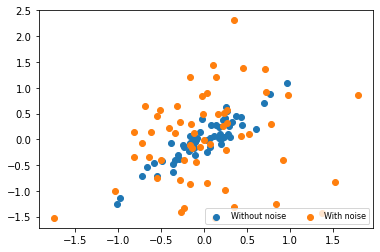

In [211]:
wn = plt.scatter(X_noise_test_original[:,0], X_noise_test_original[:,1])
yn = plt.scatter(X_noise_new[:,0], X_noise_new[:,1])

plt.savefig('noise_added_scatter_08.pdf', bbox_inches='tight')

It can be seen how it identifies a single class related to the data with noise, which means that the classifier is working correctly. Next, we perform the last test in which data without noise and data with noise are combined in equal parts to test the classifier.

In [ ]:
dataset_test_concatenate = np.concatenate([X_clean_test, X_noise_test])

nsamples, nx, ny = dataset_test_concatenate.shape
X_test_comb = dataset_test_concatenate.reshape((nsamples,nx*ny))

In [ ]:
pred = clf.predict(X_test_comb)
unique_elements, counts_elements = np.unique(pred, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

In [ ]:
pred = clfOCSV.predict(X_test_comb)
unique_elements, counts_elements = np.unique(pred, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

It can be seen that the results are very close to 50% identification for each class, so the results are correct.

Next, we will perform a series of possible attacks for the case in which the attacker has more information about the use case and how the data is being treated.

We will generate noise with random value whose maximum is the previously defined threshold (0.8). It will be applied intermittently in order to affect stages with P300 and not P300.

In [ ]:
X, Y = [], []

X = np.concatenate([target_data, nontarget_data])
Y = np.concatenate([np.zeros(X.shape[0])])

In [ ]:
cont = 0
X_mix = []
Y_mix =[]
for i in X:
    if(cont%2 == 0):
        noise = np.random.normal(0.0, np.random.uniform(0, 0.8), i.shape)
        X_mix.append(i+noise)
        Y_mix.append(1)
    else:
        X_mix.append(i)
        Y_mix.append(0)
    cont+=1

In [ ]:
X_mix_train, X_mix_test = train_test_split(X_mix, test_size=0.20, random_state=42,shuffle=False)

In [ ]:
X_mix_test = np.array(X_mix_test)

In [ ]:
nsamples, nx, ny = X_mix_test.shape
d2_test_mix_dataset = X_mix_test.reshape((nsamples,nx*ny))

pred=clf.predict(d2_test_mix_dataset)
unique_elements, counts_elements = np.unique(pred, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

In [ ]:
pred = clfOCSV.predict(d2_test_mix_dataset)
unique_elements, counts_elements = np.unique(pred, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

### Comprobación con poco ruido

In [ ]:
X, Y = [], []

X = np.concatenate([target_data, nontarget_data])
Y = np.concatenate([np.zeros(X.shape[0])])

In [ ]:
cont = 0
X_mix = []
Y_mix =[]
for i in X:
    if(cont%2 == 0):
        noise = np.random.normal(0.0, np.random.uniform(0, 0.1), i.shape)
        X_mix.append(i+noise)
        Y_mix.append(1)
    else:
        X_mix.append(i)
        Y_mix.append(0)
    cont+=1

In [ ]:
X_mix_train, X_mix_test = train_test_split(X_mix, test_size=0.20, random_state=42,shuffle=False)

In [ ]:
X_mix_test = np.array(X_mix_test)

In [ ]:
nsamples, nx, ny = X_mix_test.shape
d2_test_mix_dataset = X_mix_test.reshape((nsamples,nx*ny))

pred=clf.predict(d2_test_mix_dataset)
unique_elements, counts_elements = np.unique(pred, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

In [ ]:
pred = clfOCSV.predict(d2_test_mix_dataset)
unique_elements, counts_elements = np.unique(pred, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

# Funcionalidad extra

## Add noise only to Target data

In [ ]:
X, Y = [], []

X = np.concatenate([target_data+noise, nontarget_data])
Y = np.concatenate([np.ones(target_data.shape[0]), np.zeros(nontarget_data.shape[0])])

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

nsamples, nx, ny = X.shape
d2_train_dataset = X.reshape((nsamples,nx*ny))

clf = make_pipeline(StandardScaler(),RandomForestClassifier(max_depth=2, random_state=0))

preds = np.empty(len(Y))
for train, test in cv.split(d2_train_dataset, Y):
    clf.fit(d2_train_dataset[train], Y[train])
    preds[test] = clf.predict(d2_train_dataset[test])

# Info del proceso
target_names = ['NonNoise', 'Noise']
report = classification_report(Y, preds, target_names=target_names)
print(report)

In [ ]:
max_noise = 1
noise = np.random.normal(0.0, max_noise, nontarget_data.shape)


## Add noise only to NonTarget data

In [ ]:
X, Y = [], []

X = np.concatenate([target_data, nontarget_data+noise])
Y = np.concatenate([np.ones(target_data.shape[0]), np.zeros(nontarget_data.shape[0])])

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

nsamples, nx, ny = X.shape
d2_train_dataset = X.reshape((nsamples,nx*ny))

clf = make_pipeline(StandardScaler(),RandomForestClassifier(max_depth=2, random_state=0))

preds = np.empty(len(Y))
for train, test in cv.split(d2_train_dataset, Y):
    clf.fit(d2_train_dataset[train], Y[train])
    preds[test] = clf.predict(d2_train_dataset[test])

target_names = ['NonNoise', 'Noise']
report = classification_report(Y, preds, target_names=target_names)
print(report)

In [ ]:
X, Y = [], []

X = np.concatenate([target_data, nontarget_data])
Y = np.concatenate([np.zeros(X.shape[0])])

In [ ]:
X.shape


In [ ]:
Y.shape